<a href="https://colab.research.google.com/github/jc39963/Explainable_Techniques/blob/main/Explainable_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
### PDP, ICE, and ALE Plots
### Jenny Chen


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jc39963/Explainable_Techniques/blob/main/Explainable_Techniques.ipynb)

In [79]:
#pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

Dataset source: https://archive.ics.uci.edu/dataset/236/seeds  
* This dataset has measurements of geometrical properties of kernels belonging to three different varieties of wheat: Kama, Rosa, and Canadian which are coded as 1, 2, 3. Measurements are in cm.
* The columns are:
1. area A,

2. perimeter P,

3. compactness C = $\frac{4\pi A}{P^2}$,

4. length of kernel,

5. width of kernel,

6. asymmetry coefficient

7. length of kernel groove.


In [81]:
dataset = pd.read_table('/content/seeds_dataset.txt', header=None)

In [82]:
dataset

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [83]:
# setting column names
headers = ['Area', 'Perimeter', 'Compactness', 'Length', 'Width', 'Asymmetry', 'Groove Length', 'Class']
dataset.columns = headers

In [84]:
dataset['Class'] = dataset['Class'].astype('category')

#### EDA  
* Code referenced from this notebook for EDA: https://github.com/AIPI510/aipi510-fall25/blob/main/starters/exploratory_data_analysis.ipynb

In [85]:
# checking Data Structure
print("Data Structure")
print("---------------")
print(f"Dimensions: {dataset.shape}")
print(f"Data Types:\n{dataset.dtypes}")
print(f"Missing Values:\n{dataset.isnull().sum()}")

Data Structure
---------------
Dimensions: (210, 8)
Data Types:
Area              float64
Perimeter         float64
Compactness       float64
Length            float64
Width             float64
Asymmetry         float64
Groove Length     float64
Class            category
dtype: object
Missing Values:
Area             0
Perimeter        0
Compactness      0
Length           0
Width            0
Asymmetry        0
Groove Length    0
Class            0
dtype: int64


* Variables are all numeric except class which I turned into a category.

In [86]:
# Descriptive Statistics
print("\nDescriptive Statistics")
print("----------------------")
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
print("Central Tendency Measures:")
print(dataset[numeric_columns].describe().loc[['mean', '50%']])
print("\nDispersion Measures:")
print(dataset[numeric_columns].describe().loc[['std', 'min', 'max']])

# Check for distribution normality (skewness and kurtosis)
print("\nDistribution Measures:")
print("------------------------")
print(dataset[numeric_columns].skew())
print(dataset[numeric_columns].kurt())


Descriptive Statistics
----------------------
Central Tendency Measures:
           Area  Perimeter  Compactness    Length     Width  Asymmetry  \
mean  14.847524  14.559286     0.870999  5.628533  3.258605   3.700201   
50%   14.355000  14.320000     0.873450  5.523500  3.237000   3.599000   

      Groove Length  
mean       5.408071  
50%        5.223000  

Dispersion Measures:
          Area  Perimeter  Compactness    Length     Width  Asymmetry  \
std   2.909699   1.305959     0.023629  0.443063  0.377714   1.503557   
min  10.590000  12.410000     0.808100  4.899000  2.630000   0.765100   
max  21.180000  17.250000     0.918300  6.675000  4.033000   8.456000   

     Groove Length  
std        0.49148  
min        4.51900  
max        6.55000  

Distribution Measures:
------------------------
Area             0.399889
Perimeter        0.386573
Compactness     -0.537954
Length           0.525482
Width            0.134378
Asymmetry        0.401667
Groove Length    0.561897
dtype: 

**Descriptive Statistics**

* The mean and median for all variables in this data are similar suggesting a pretty symmetric distribution.

**Dispersion Measures**

We can see the range of each variable and the typical deviation from the mean.  

**Distribution Measures: Skewness and kurtosis of the numerical features.**

Skewness values close to 0 indicate a symmetric distribution, while positive or negative values indicate right or left skew, respectively. Based on the values here, only Compactness seems to have a left skew and overall they all seem pretty symmetric.  Kurtosis indicates the "tailedness" of the distribution; values close to 0 suggest a normal distribution, while higher values suggest heavier tails. It seems that Area, Perimeter, and Width may have heavier tails.

In [87]:
# Data Quality
print("\nData Quality")
print("------------")
print(f"Duplicated Rows: {dataset.duplicated().sum()}")



Data Quality
------------
Duplicated Rows: 0


No duplicates found

                   Area  Perimeter  Compactness    Length     Width  \
Area           1.000000   0.994341     0.608288  0.949985  0.970771   
Perimeter      0.994341   1.000000     0.529244  0.972422  0.944829   
Compactness    0.608288   0.529244     1.000000  0.367915  0.761635   
Length         0.949985   0.972422     0.367915  1.000000  0.860415   
Width          0.970771   0.944829     0.761635  0.860415  1.000000   
Asymmetry     -0.229572  -0.217340    -0.331471 -0.171562 -0.258037   
Groove Length  0.863693   0.890784     0.226825  0.932806  0.749131   
Class         -0.346058  -0.327900    -0.531007 -0.257269 -0.423463   

               Asymmetry  Groove Length     Class  
Area           -0.229572       0.863693 -0.346058  
Perimeter      -0.217340       0.890784 -0.327900  
Compactness    -0.331471       0.226825 -0.531007  
Length         -0.171562       0.932806 -0.257269  
Width          -0.258037       0.749131 -0.423463  
Asymmetry       1.000000      -0.011079  0.57727

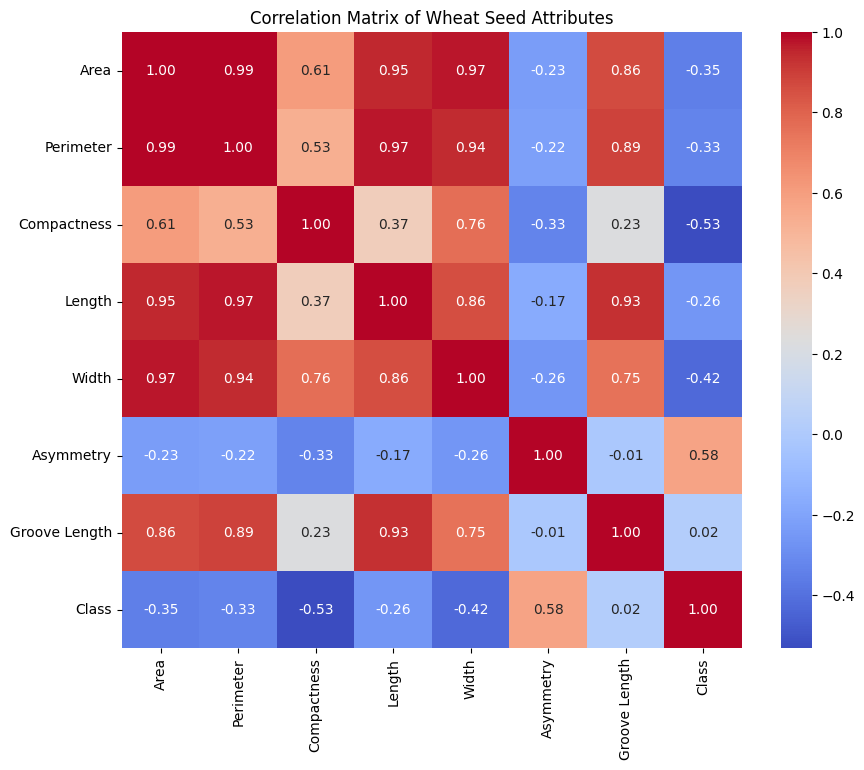

In [88]:
correlation_matrix = dataset.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Wheat Seed Attributes')
plt.show()

**Correlation**
* It looks like variables like Area, Perimeter, Length, and Width are highly correlated, which makes sense given Area and Perimeter are calculated generally with Length and Width. Groove Length of a kernel is also highly correlated since that likely also has to do with overall Length of the seed.

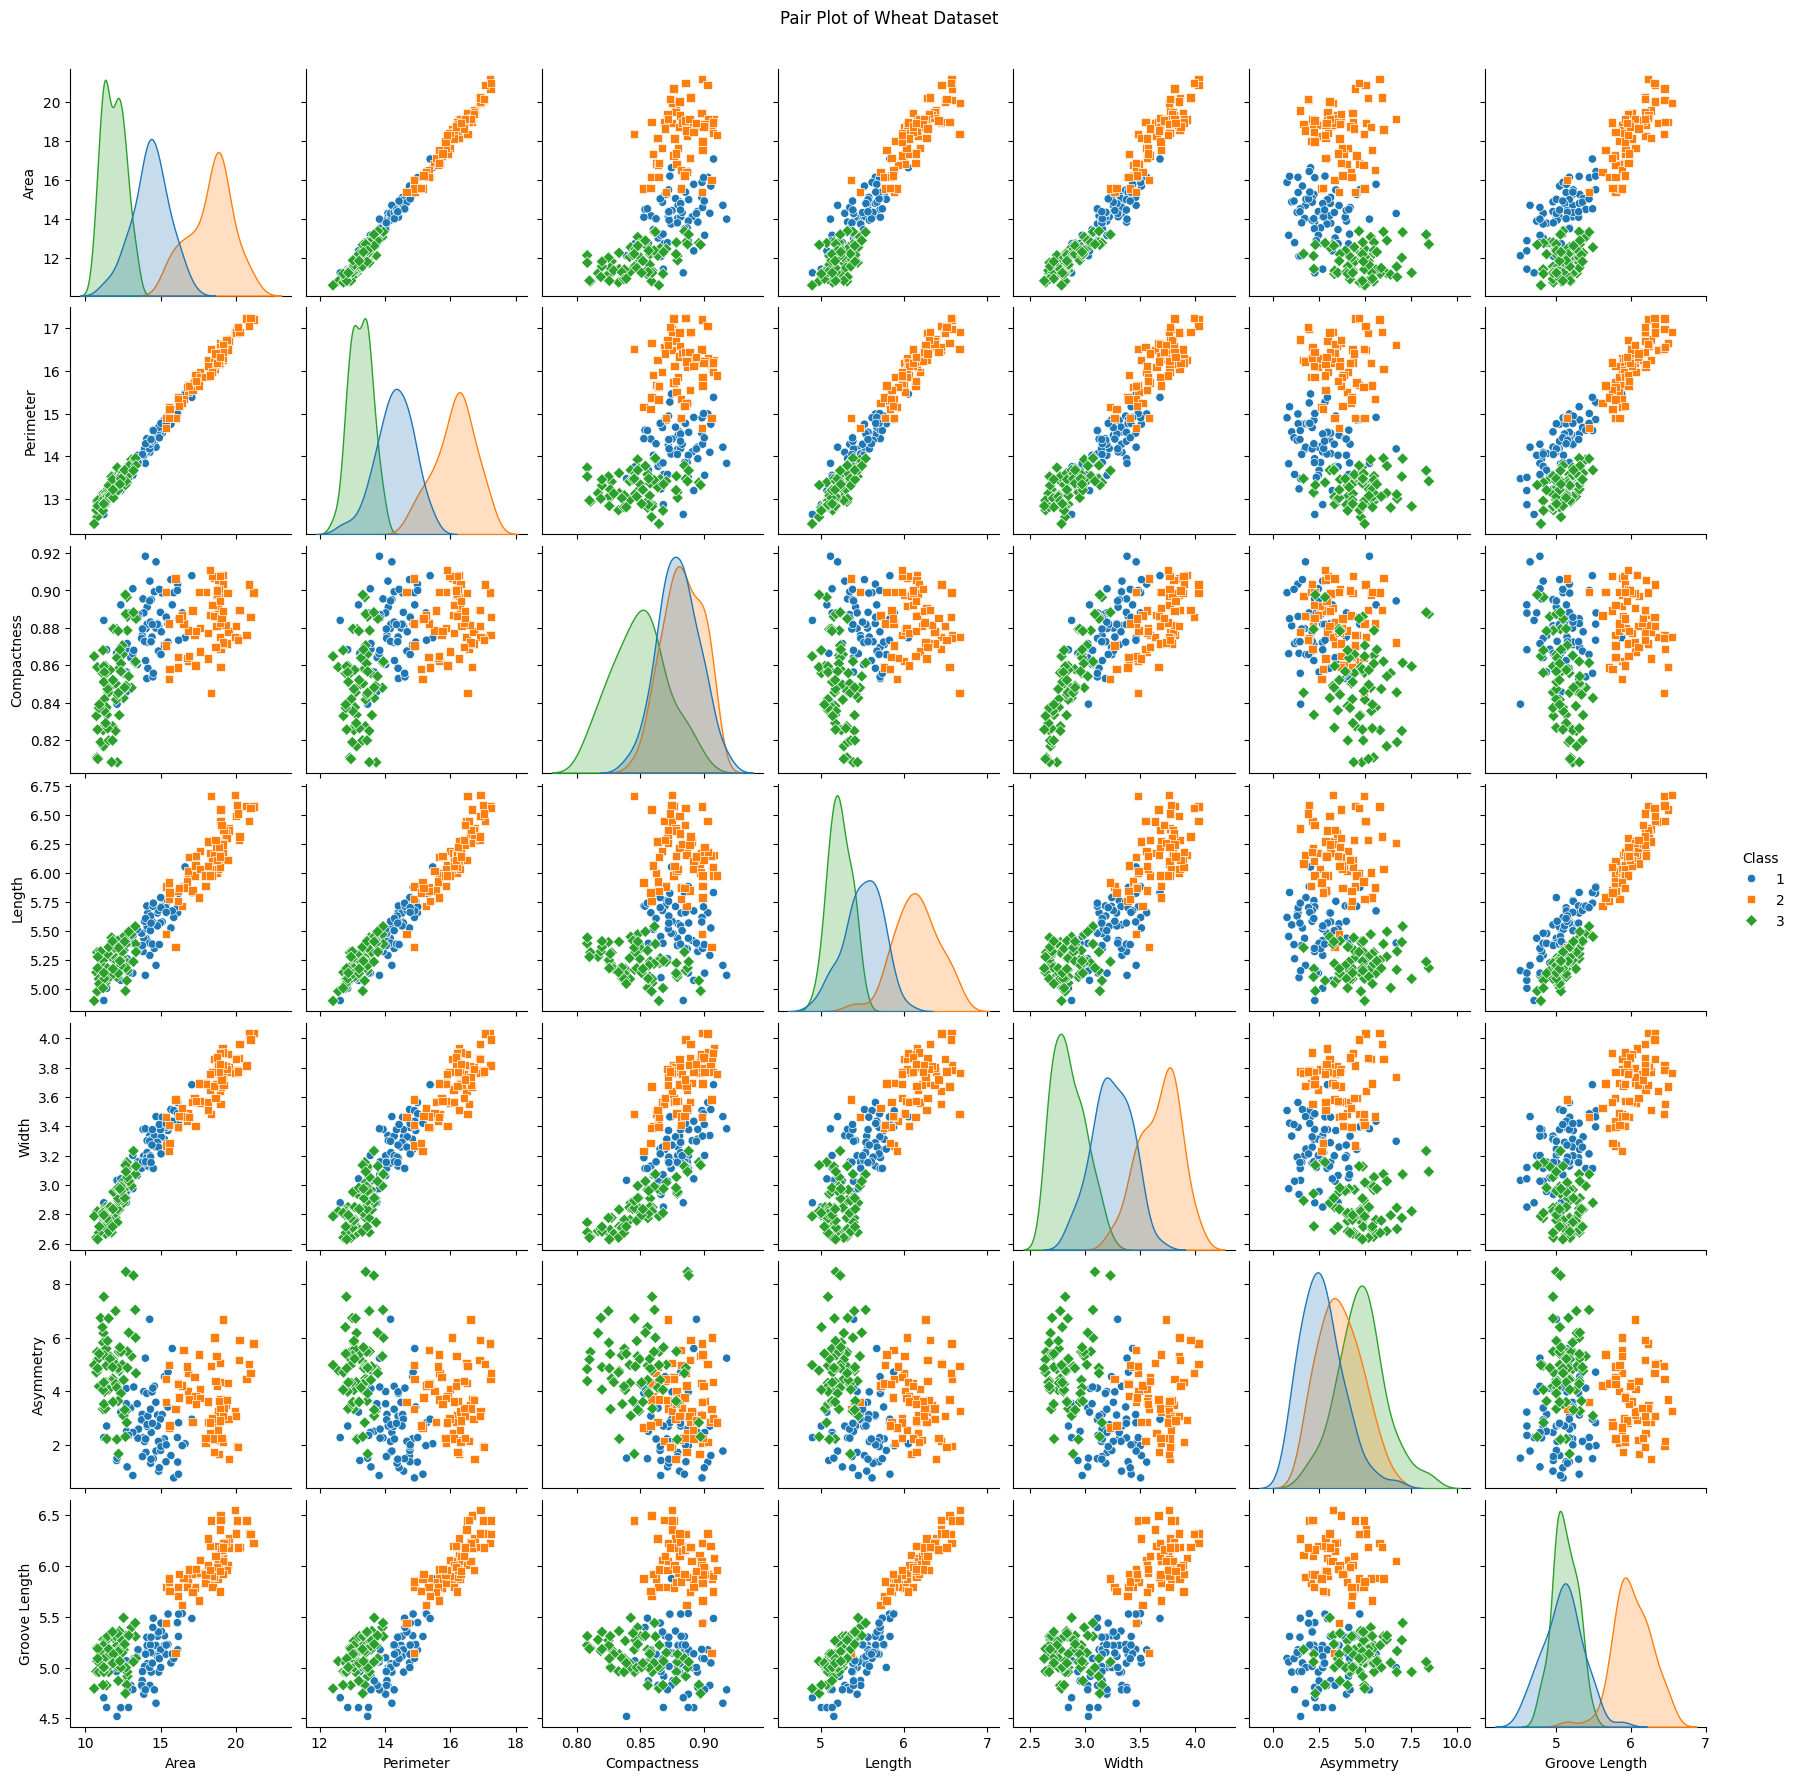

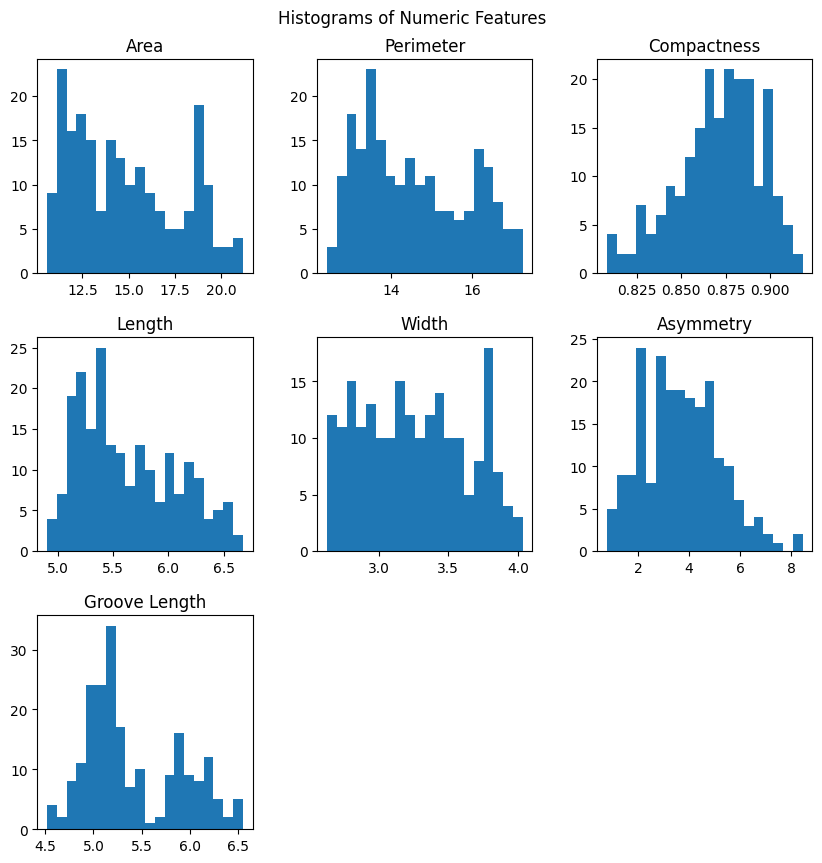

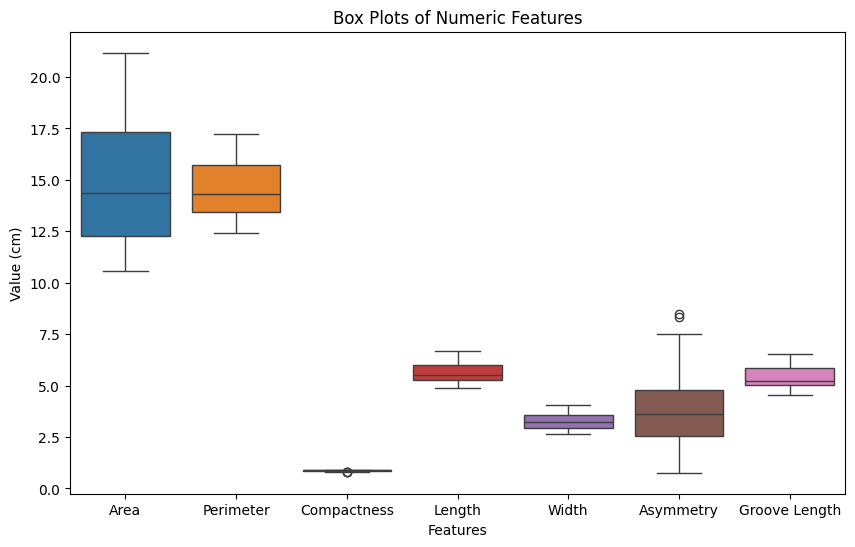

In [89]:
# Data Visualization
sns.pairplot(dataset, hue='Class', markers=["o", "s", "D"])
plt.suptitle('Pair Plot of Wheat Dataset', y=1.02)
plt.show()

# Visualize distributions
dataset[numeric_columns].hist(bins=20, figsize=(10,10), grid=False)
plt.suptitle('Histograms of Numeric Features', y=0.93)
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset[numeric_columns])
plt.title('Box Plots of Numeric Features')
plt.xlabel('Features')
plt.ylabel('Value (cm)')
plt.show()


**Pairplots**
* This visualization shows the relationships between pairs of features and how they differ across species. Clusters of points indicate potential separability of species based on feature measurements. We can see pretty clear separation of clusters for pretty much all of the pairs of variables.

**Histograms**
* Looking at the distributions of the numeric variables, we see Groove Length looks bimodal suggesting maybe a separation across classes. Area and Perimeter could potentially have 3 peaks, perhaps for each class.

**Box plots**
* Asymmetry seems to have some potential outliers, Area has a larger spread in general compared to other variables, Compactness does not have a large spread.  

#### Modeling
* I will try using a Random Forest for this multi class classification problem of utilizing the variables to predict the class of wheat seed.

In [90]:
# get features and outcome variables
X = dataset.drop('Class', axis=1)
y = dataset['Class']



# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# train
rf.fit(X_train, y_train.values)

RandomForestClassifier(random_state=42)

**Evaluate Model**

In [92]:
# predict on the test data
y_pred = rf.predict(X_test)

# evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print("\nClassification Report:\n", report)

Accuracy: 0.833

Classification Report:
               precision    recall  f1-score   support

           1       0.64      0.82      0.72        11
           2       1.00      1.00      1.00        14
           3       0.86      0.71      0.77        17

    accuracy                           0.83        42
   macro avg       0.83      0.84      0.83        42
weighted avg       0.85      0.83      0.84        42



#### PDP

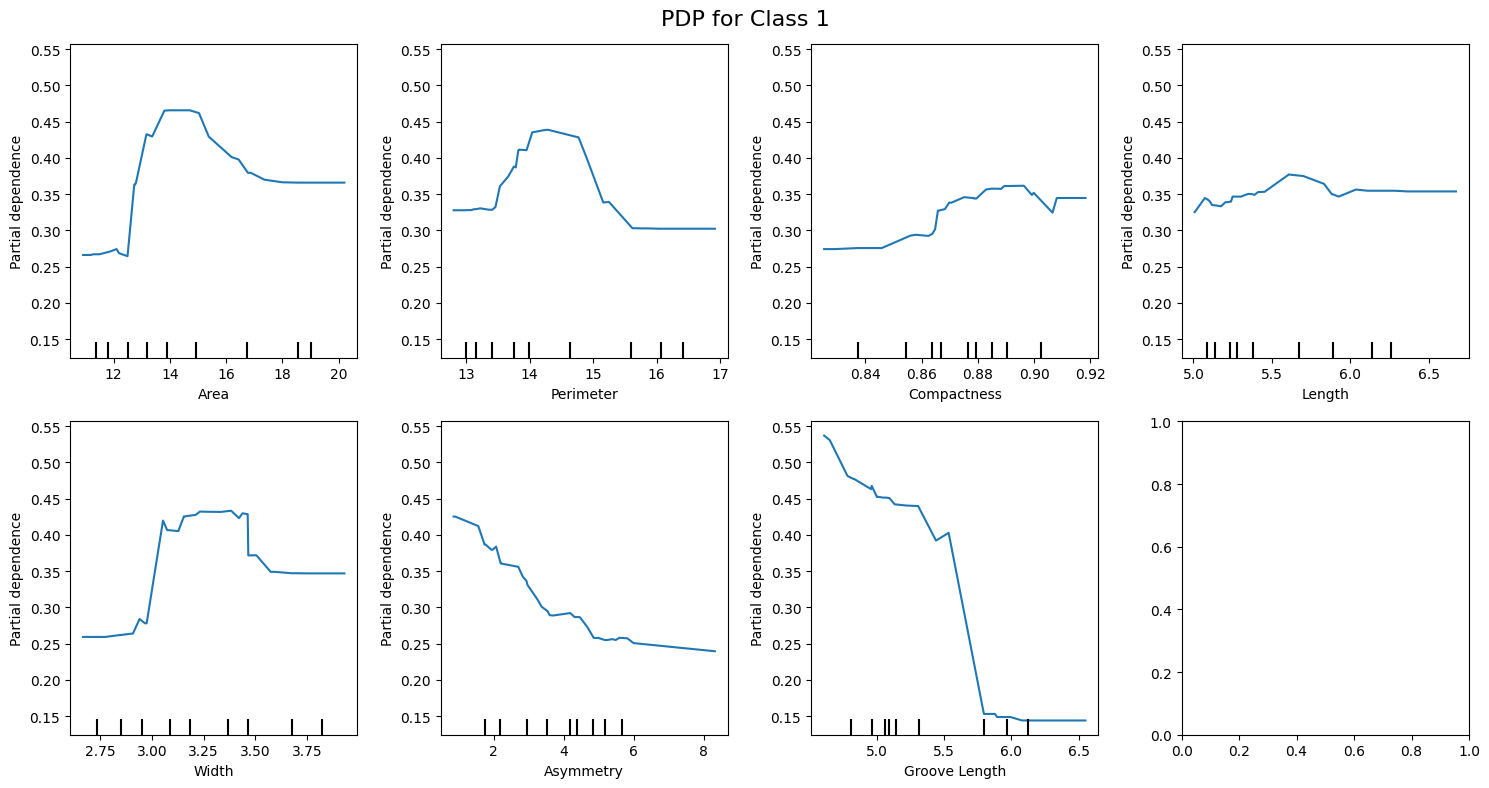

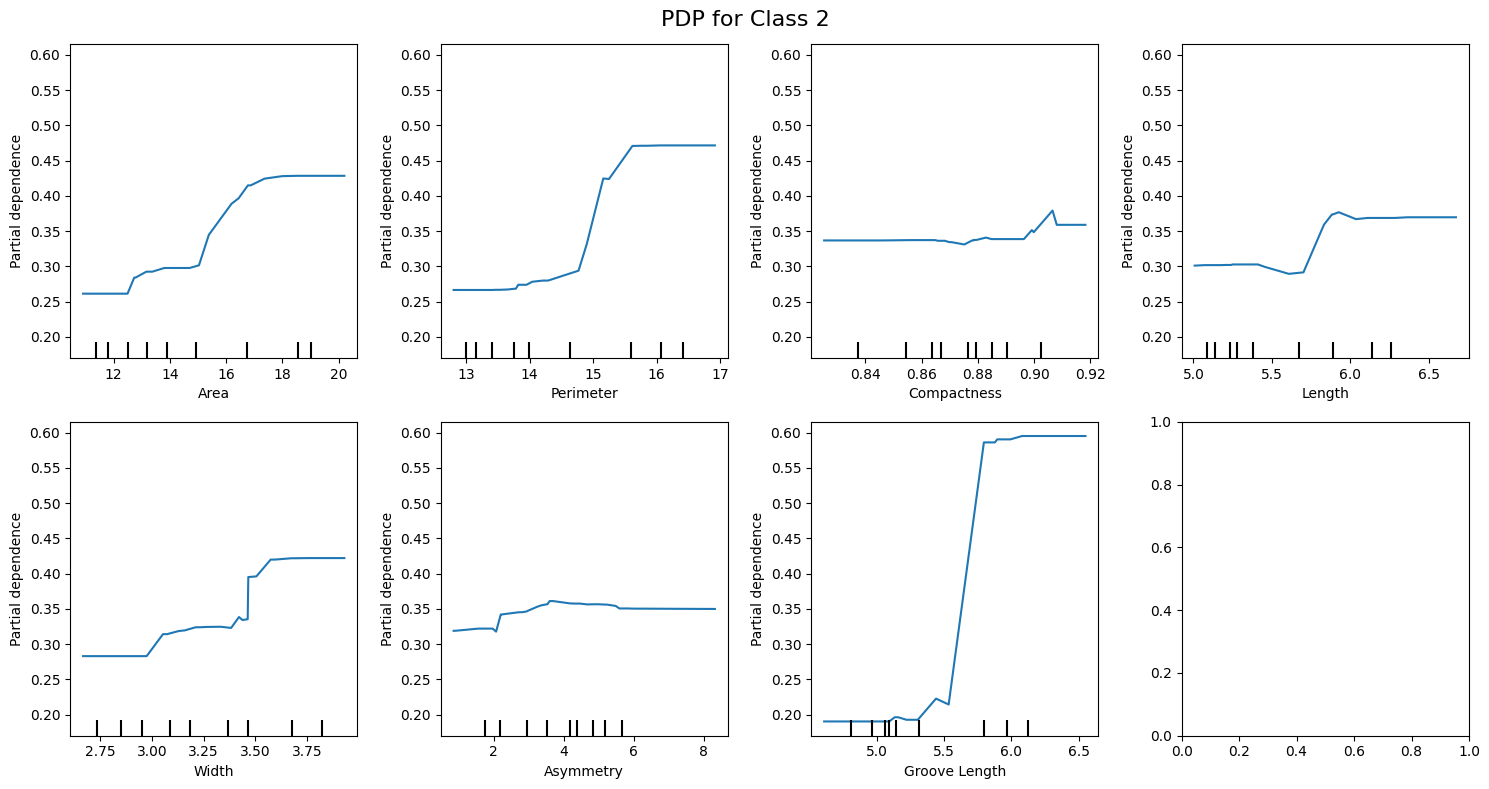

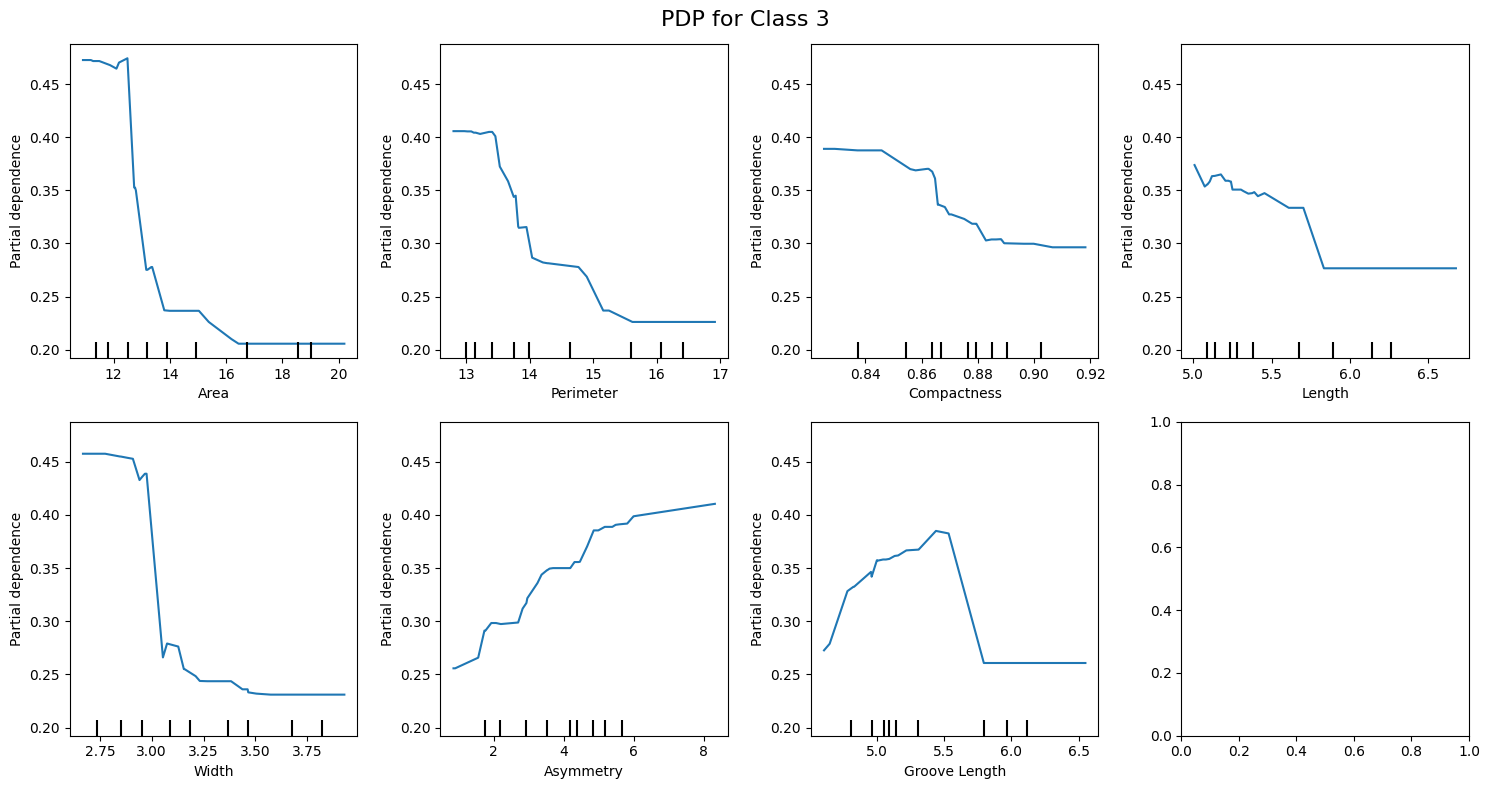

In [93]:
# code adapted from XAI global explanations notebook
# get features
features = ["Area", 'Perimeter', 'Compactness', 'Length', 'Width', 'Asymmetry', 'Groove Length']

# get target variable classes
target_classes = [1, 2, 3]

# asked ChatGPT-5 at 5:04 pm on 9/28 how to make sure I can label each feature for each class
# when plotting so that I don't have to do individual plots for each feature and class
for target_class in target_classes:
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

    # flatten axes into a 1D array
    ax = ax.ravel()

    # drop the unused extra axis (8th one)
    ax = ax[:len(features)]

    display = PartialDependenceDisplay.from_estimator(
        rf, X_test, features, kind="average",
        target=target_class, feature_names=X.columns, ax=ax
    )

    fig.suptitle(f"PDP for Class {target_class}", fontsize=16)
    plt.tight_layout()
    plt.show()



**Interpretation**
* For Groove Length, it seems that for Class 1, larger Groove Length (>5.5 cm)  drastically decreased the probability of being Class 1 while Class 2 Groove Length shows the complete opposite trend.
* For Area and Perimeter, their trends look similar across all classes, where having a lower Area and Perimeter (< 14 cm) increases probability for Class 3, an Area and Perimeter around 14-16 cm is for Class 1, and bigger Area and Perimeter for Class 2.
* Length and Width have similar trends as Area and Perimeter for each class but less extreme, however they show similar shapes as Area and Perimeter where for Class 1, they are higher partial dependence for feature values in the middle, for Class 2, they show higher partial dependence for higher feature values, and for Class 3, they show higher partial dependence for lower feature values.  


However, as we saw in the correlation matrix, Area, Perimeter, Length and Width are highly correlated. With PDPs, this could distort the curve since the PDP is trying out relationships that wouldn't actually exist in the data (e.g. high Area with low Length or Perimeter or Width) because the features are actually correlated.

#### ICE Plots


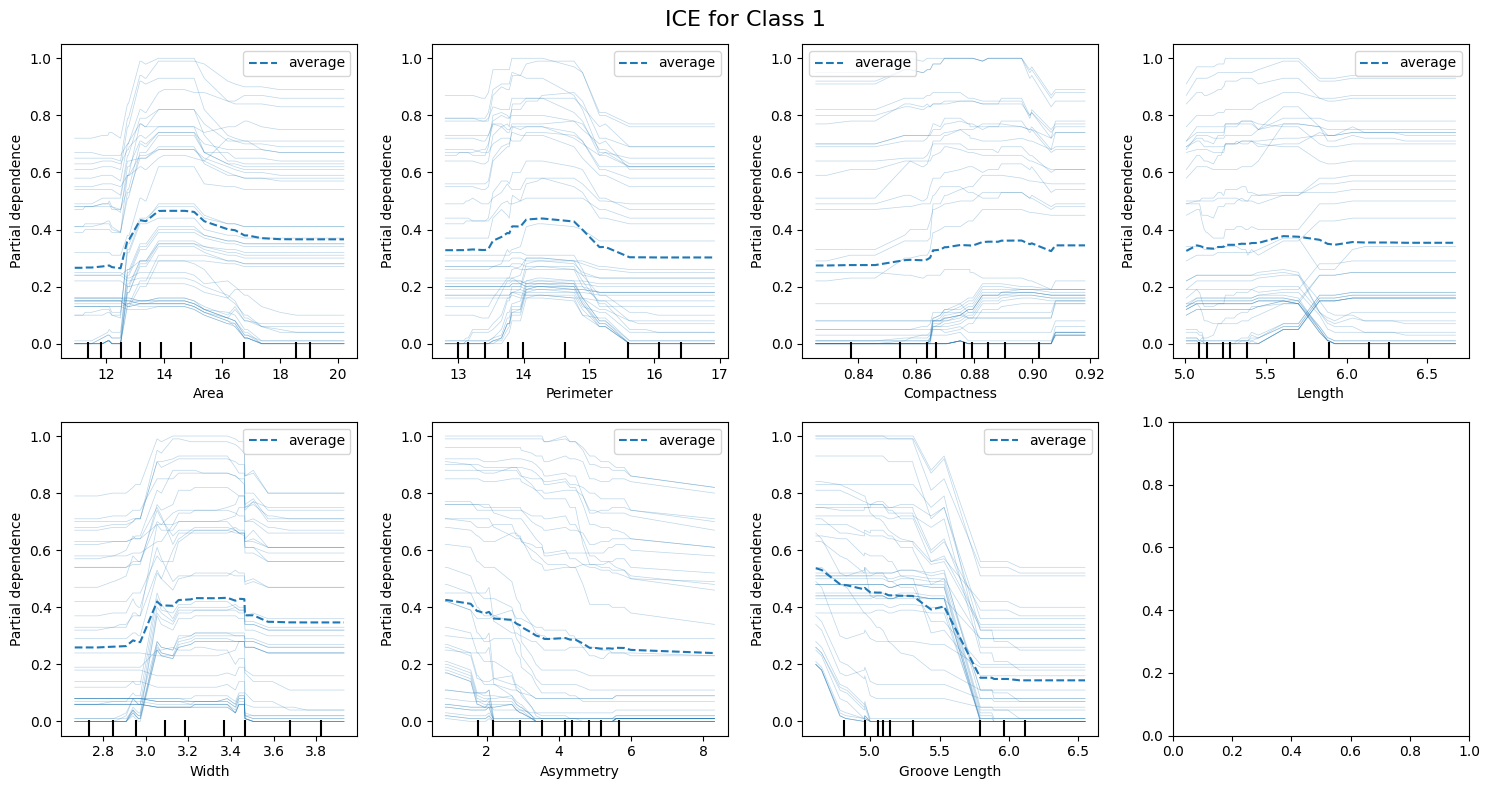

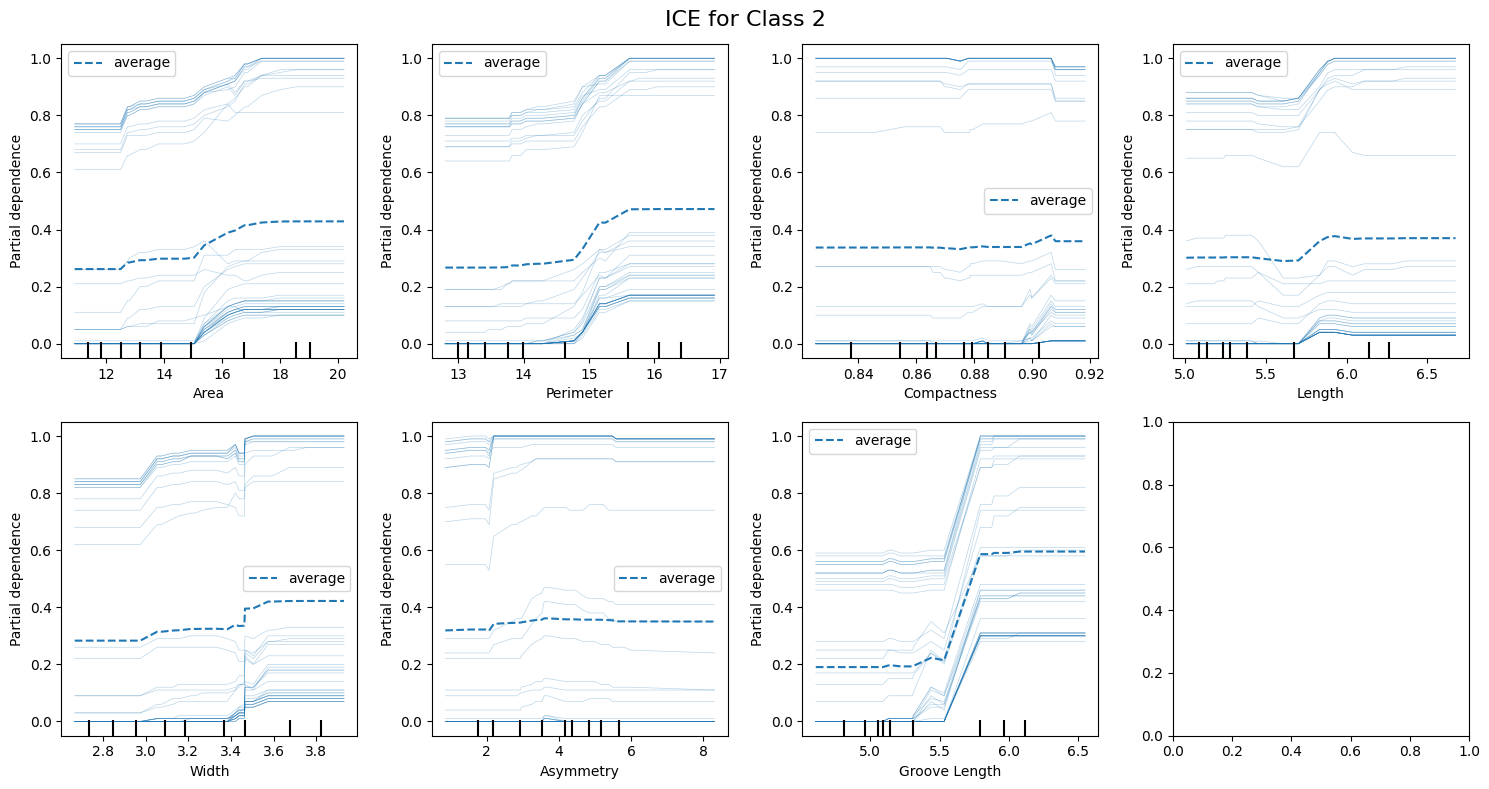

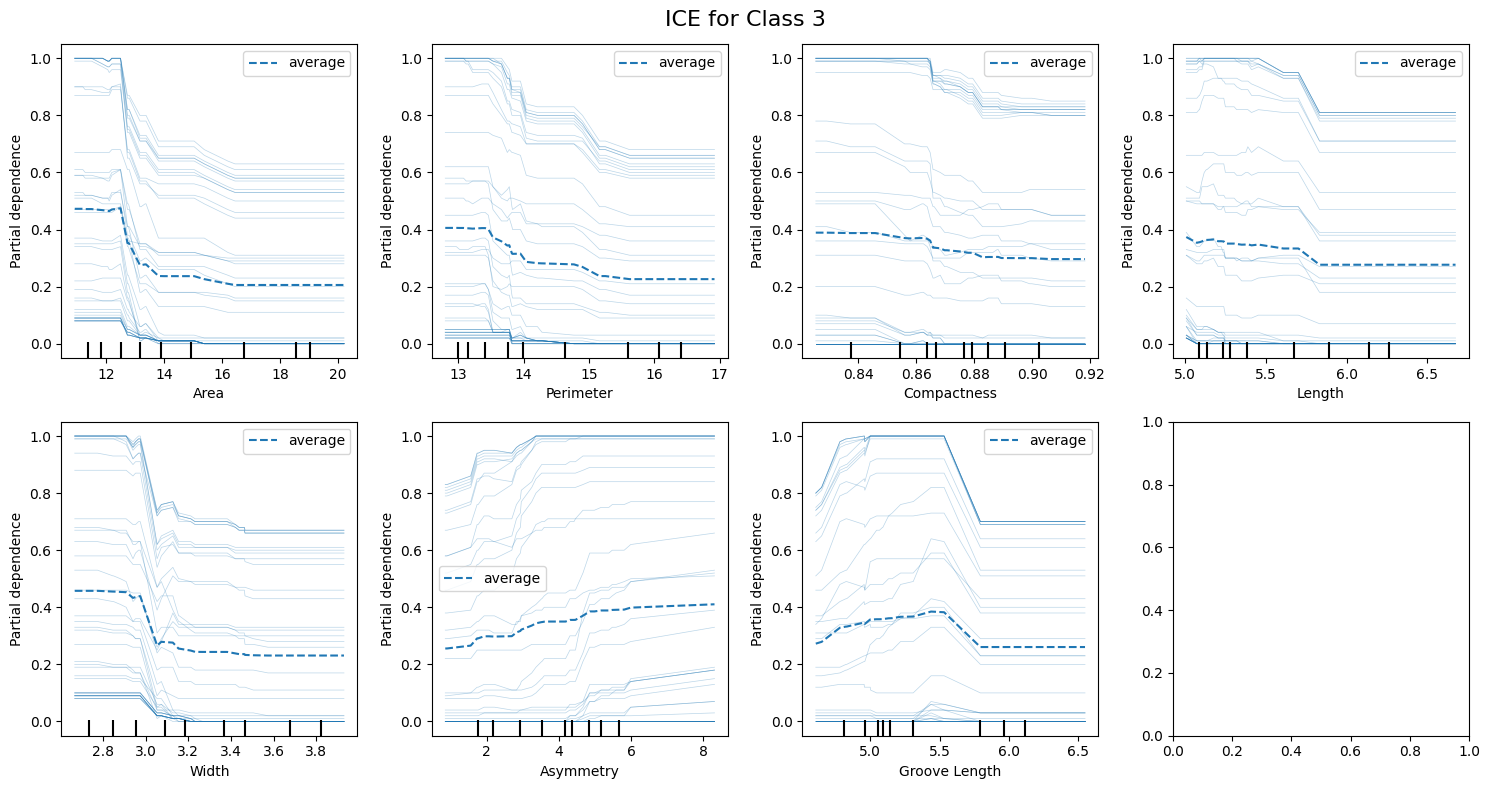

In [94]:
# using same code as PDP but with different kind to show ICE and PDP average
for target_class in target_classes:
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

    # flatten axes into a 1D array
    ax = ax.ravel()

    # drop the unused extra axis (8th one)
    ax = ax[:len(features)]

    display = PartialDependenceDisplay.from_estimator(
        rf, X_test, features, kind="both",
        target=target_class, feature_names=X.columns, ax=ax
    )

    fig.suptitle(f"ICE for Class {target_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

**Interpretation**  
* The ICE plots allow us to see more individual variation across features and classes, while also showing the PDP line so we can see the average which we had plotted in the PDP above.  
* This allows us to see that there is more complexity than the PDP might show us. For example, we see different shapes in the individual lines for Groove Length for Class 3 and Length for Class 1. Though overall, it does look like the trends / shapes are similar across most individual lines and reflected in the average.

In [95]:


# Compute permutation importances from local explainability notebook
perm_imp = permutation_importance(rf, X_test, y_test,
                           n_repeats=30,
                           random_state=0)


# Print the mean and standard deviation of permutation importances for each feature

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] - 2 * perm_imp.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
              f"{perm_imp.importances_mean[i]:.3f}"
              f" +/- {perm_imp.importances_std[i]:.3f}")



Groove Length0.113 +/- 0.032


#### ALE Plot  
* Based on the feature perumtation importance, Groove Length seemed to be important so I will plot that but also will do ALE plots for Area, Perimeter, Width, and Length since those were correlated just to compare to PDP and ICE plots

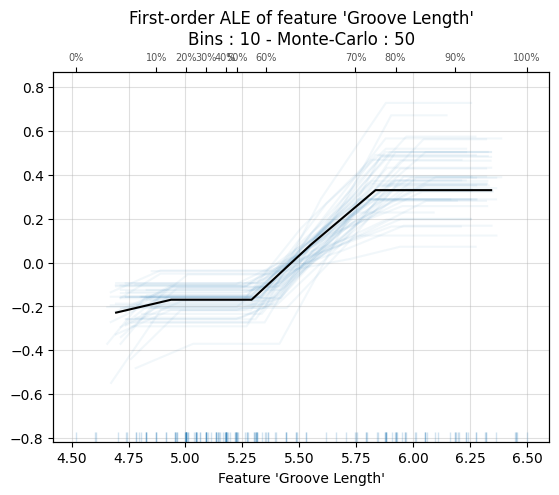

<Axes: title={'center': "First-order ALE of feature 'Groove Length'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Groove Length'">

In [96]:
# from local explainability notebook
ale_plot(
        rf,
        X_train,
        'Groove Length',
        bins=10,
        monte_carlo = True,
        monte_carlo_rep=50,
        monte_carlo_ratio=0.5,
    )

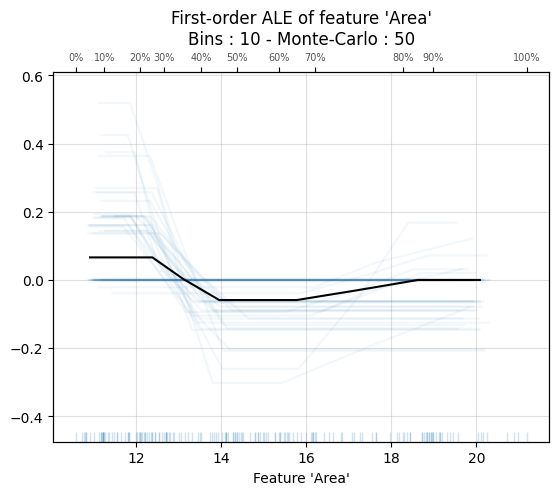

<Axes: title={'center': "First-order ALE of feature 'Area'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Area'">

In [97]:
# from local explainability notebook on github
ale_plot(
        rf,
        X_train,
        'Area',
        bins=10,
        monte_carlo = True,
        monte_carlo_rep=50,
        monte_carlo_ratio=0.5
    )

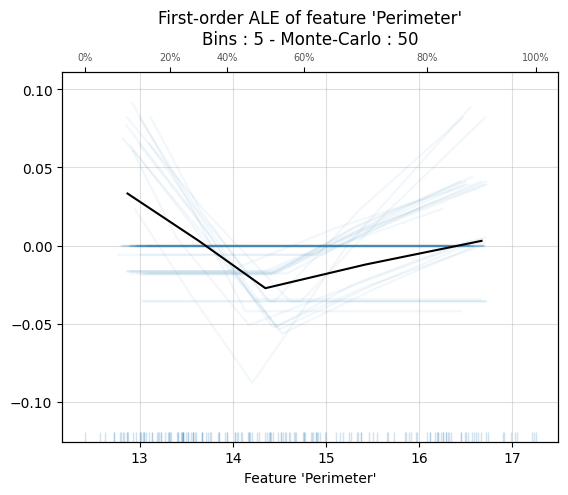

<Axes: title={'center': "First-order ALE of feature 'Perimeter'\nBins : 5 - Monte-Carlo : 50"}, xlabel="Feature 'Perimeter'">

In [98]:
ale_plot(
        rf,
        X_train,
        'Perimeter',
        bins=5, #change bin number to see shape
        monte_carlo = True,
        monte_carlo_rep=50,
        monte_carlo_ratio=0.5
    )

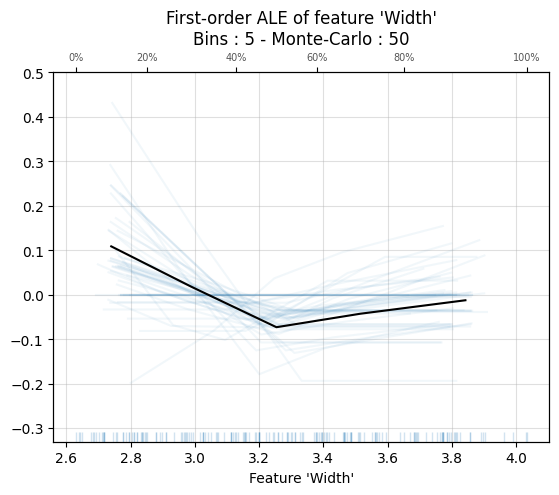

<Axes: title={'center': "First-order ALE of feature 'Width'\nBins : 5 - Monte-Carlo : 50"}, xlabel="Feature 'Width'">

In [99]:
ale_plot(
        rf,
        X_train,
        'Width',
        bins=5,
        monte_carlo = True,
        monte_carlo_rep=50,
        monte_carlo_ratio=0.5
    )

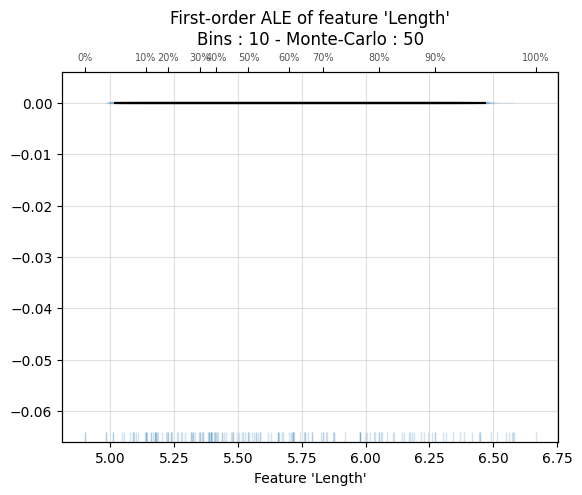

<Axes: title={'center': "First-order ALE of feature 'Length'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Length'">

In [100]:
#tried different bin numbers, was flat for all of them
ale_plot(
        rf,
        X_train,
        'Length',
        bins=10,
        monte_carlo = True,
        monte_carlo_rep=50,
        monte_carlo_ratio=0.5
    )

**Interpretation**:

* Groove Length seems to have a semi significant impact on predictions where values increasing from 5.25 cm - 6 cm showing that it increases the prediction relative to the baseline. In other feature values for Groove Length it is flat.
* Area does not seem to have very big of an impact with a bit of a dip to below 0 (baseline) from 12-14 cm squared before going back to the baseline. This is pretty different from the Area PDP and ICE Plots for Class 1 where it shows the opposite trend - an increase then a decrease.
* For Perimeter and Width, we see the same, a V shaped trendn in this ALE plot showing increasing feature value decreasing predictions, but then an upward curve where it increases a bit, but neither seem to have much importance as they are not very steep. Length is flat and likely not important as a feature.



*Note*: This Aleplot library seems to only show the feature importance for the first class of a Multiclass classification problem. Therefore, these interpretations are with comparison to the ICE and PDPs for Class 1.  



**Overall**:
* We see that PDP and ALE plots show different things. This is likely due to my variables, especially Area, Perimeter, Length, Width, and Groove Length being highly correlated, thus impacting PDP and ICE plots negatively since they wouldn't be able to fully represent the relationships that exist in the data between features given the nature of the plots - holding other features constant while changing values of the feature of interest. Meanwhile, ALE plots are better for correlated features since they look only at actual observed data points rather than all possible combinations, therefore not falsely making up data or relationships between features that doesn't exist in the data. Additionally, for ALE plots, I chose to just plot the features that I saw were highly correlated in PDP and the ones that were seen as important from permutation feature importance that I ran, which only showed Groove Length (likely because other features were either highly correlated - which we know - or did not add much beyond noise), so I could compare them especially to what I saw in the PDP and ICE plots to show and see that the correlations we saw earlier were reflected in how these plots showed feature importance and explainability.